In [1]:
import re
import os

benchmarks = {
    '600': 'perlbench',
    '602': 'gcc',
    '603': 'bwaves',
    '605': 'mcf',
    '607': 'cactuBSSN',
    '619': 'lbm',
    '620': 'omnetpp',
    '621': 'wrf',
    '623': 'xalancbmk',
    '625': 'x264',
    '627': 'cam4',
    '628': 'pop2',
    '631': 'deepsjeng',
    '638': 'imagick',
    '641': 'leela',
    '644': 'nab',
    '648': 'exchange2',
    '649': 'fotonik3d',
    '654': 'roms',
    '657': 'xz'
}

def extract_metrics(filename):
    IPC = None
    L2C_Avg_Miss_Latency = None
    L2C_Misses = None
    Prefetches_Requested = None
    Prefetches_Issued = None
    Prefetches_Useful = None

    with open(filename, 'r') as f:
        for line in f:
            # Extract IPC
            if line.startswith('CPU 0 cumulative IPC'):
                IPC = float(line[22:line.find('instructions')-1])

            # Extract L2C Average Miss Latency
            elif line.startswith('cpu0->cpu0_L2C AVERAGE MISS LATENCY'):
                L2C_Avg_Miss_Latency = float(line.split(':')[1].split()[0])

            # Extract L2C Misses
            elif 'cpu0->cpu0_L2C TOTAL' in line and 'MISS:' in line:
                parts = line.split()
                L2C_Misses = int(parts[7])  # "MISS:" value

            # Extract Prefetch Metrics
            elif 'cpu0->cpu0_L2C PREFETCH REQUESTED' in line:
                parts = line.split()
                Prefetches_Requested = int(parts[3])
                Prefetches_Issued = int(parts[5])
                Prefetches_Useful = int(parts[7])

    return IPC, L2C_Avg_Miss_Latency, L2C_Misses, Prefetches_Requested, Prefetches_Issued, Prefetches_Useful

def process_results_folder(folder_path):
    results = []
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".txt"):
                filepath = os.path.join(root, filename)
                benchmark_key = filename.split('_')[-1].split('.')[0]
                benchmark = benchmarks.get(benchmark_key, "Unknown Benchmark")
                # ipc, latency, coverage, accuracy = parse_simulation_results(filepath)
                prefetcher = os.path.basename(root)  # Use folder name as prefetcher name
                ipc, l2c_miss_latency, l2c_misses, prefetch_requested, prefetch_issued, prefetch_useful = extract_metrics(filepath)
                # Append results to the list 
                results.append({
                    "Prefetcher": prefetcher,
                    "Benchmark": benchmark,  # Simplified to just the benchmark name
                    "IPC": ipc,
                    "L2C Miss Latency": l2c_miss_latency,
                    "L2C Misses": l2c_misses,
                    "Prefetch Requested": prefetch_requested,
                    "Prefetch Issued": prefetch_issued,
                    "Prefetch Useful": prefetch_useful,
                })  
                # results.append({
                #     "Prefetcher": prefetcher,
                #     "Benchmark": benchmark,  # Simplified to just the benchmark name
                #     "IPC": ipc,
                #     "L2C Miss Latency": latency,
                #     "Prefetch Coverage (%)": coverage,
                #     "Prefetch Accuracy (%)": accuracy
                # })
    return results

folder_path = "."
results = process_results_folder(folder_path)


In [2]:
# convert results to a pandas dataframe
import pandas as pd
results_df = pd.DataFrame(results)
# Save the results to a CSV file
# results_df.to_csv('run2_results.csv', index=False)
# results_df

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grouped_bar_chart(results_df, prefetchers, metric):
    # Filter the dataframe for the selected prefetchers
    filtered_df = results_df[results_df['Prefetcher'].isin(prefetchers)]
    
    # Ensure the Prefetcher column is ordered as in the prefetchers list
    # filtered_df['Prefetcher'] = pd.Categorical(filtered_df['Prefetcher'], categories=prefetchers, ordered=True)
    
    # Pivot the dataframe to have benchmarks as rows and prefetchers as columns
    pivot_df = filtered_df.pivot(index='Benchmark', columns='Prefetcher', values=metric)
    
    # Plot the grouped bar chart
    ax = pivot_df.plot(kind='bar', figsize=(12, 6), width=0.8)
    ax.set_title(f'{metric}', fontsize=16)
    ax.set_ylabel(metric, fontsize=14)
    ax.set_xlabel('Benchmark', fontsize=14)
    ax.legend(title='Prefetcher', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.tight_layout()
    plt.show()

In [5]:
results_df['Coverage (%)'] = results_df['Prefetch Useful'] / results_df['L2C Misses'] * 100
results_df['Accuracy (%)'] = results_df['Prefetch Useful'] / results_df['Prefetch Requested'] * 100
results_df[results_df["Benchmark"] == "gcc"]

,Prefetcher,Benchmark,IPC,L2C Miss Latency,L2C Misses,Prefetch Requested,Prefetch Issued,Prefetch Useful,Coverage (%),Accuracy (%)
2,ghb_stride,gcc,0.8409,173.40,4866800.0,3262096.0,3262096.0,2402598.0,49.367100,73.651971
22,ghb_stride_fdp,gcc,0.8409,173.60,4865849.0,3300768.0,3300768.0,2402236.0,49.369308,72.778093
42,ip_stride,gcc,0.7437,168.70,4574053.0,2307513.0,2307513.0,1878331.0,41.064916,81.400668
62,next_line,gcc,0.9140,98.05,7406468.0,4555104.0,4555104.0,4029813.0,54.409376,88.468079
82,no_pref,gcc,0.5362,167.00,4310698.0,0.0,0.0,0.0,0.000000,NaN


In [6]:
results_df['Prefetcher'].unique()

array(['.', 'ghb_stride', 'ghb_stride_fdp', 'ip_stride', 'next_line',
       'no_pref'], dtype=object)

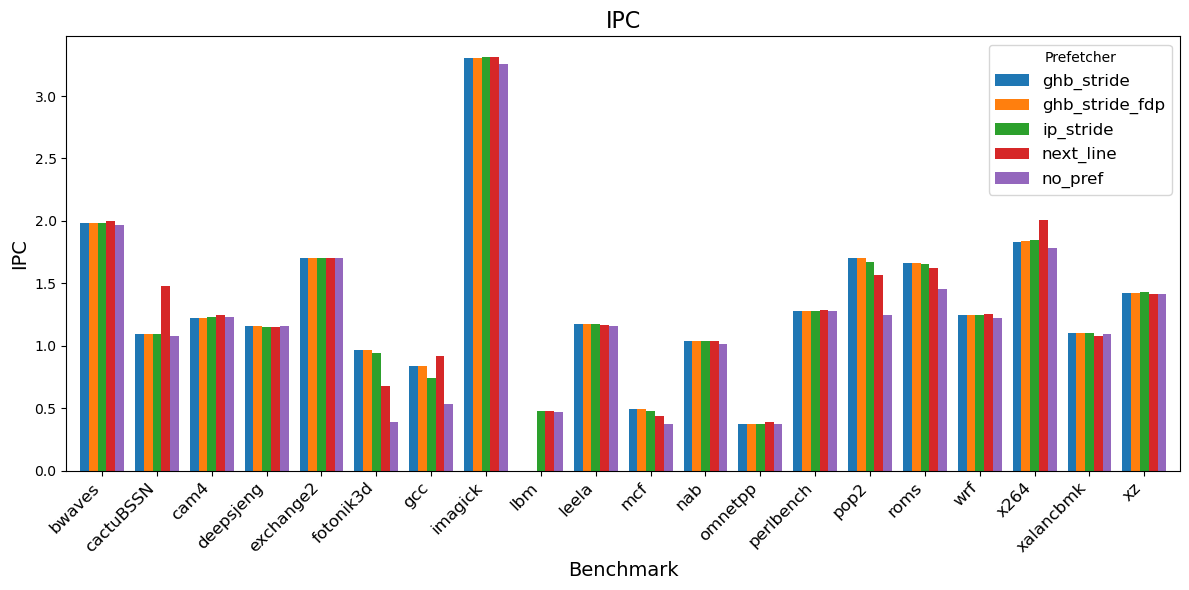

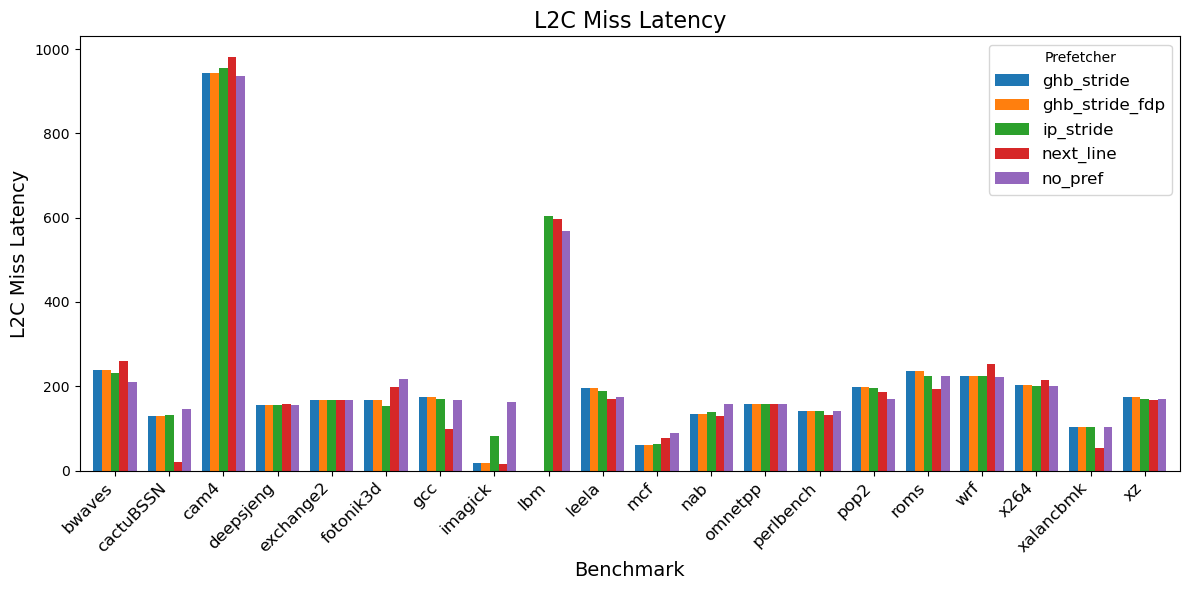

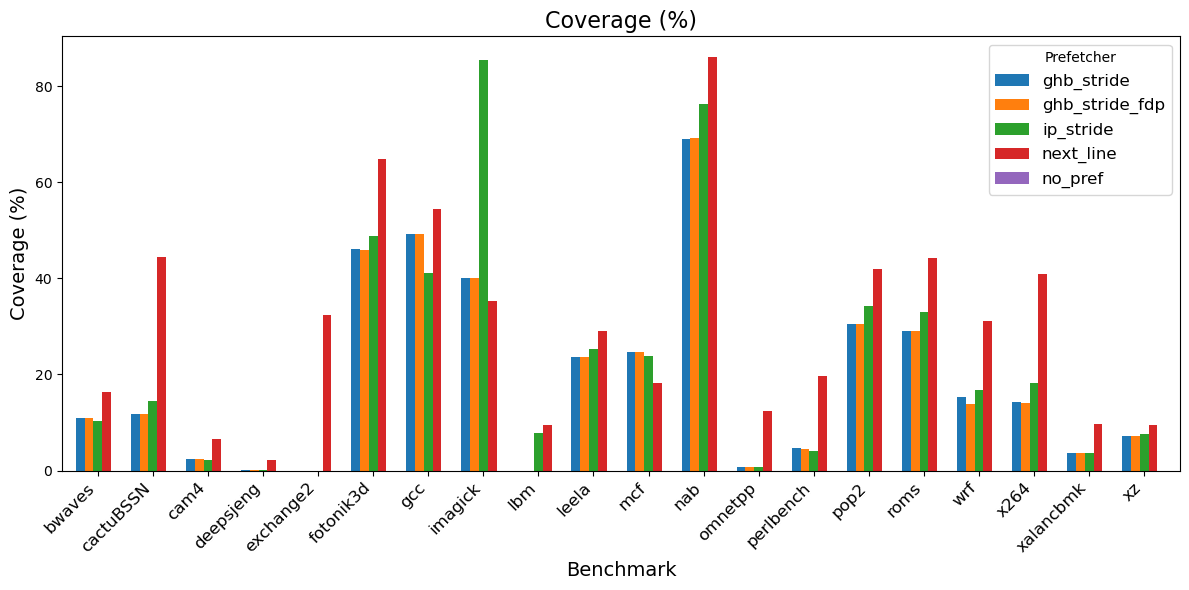

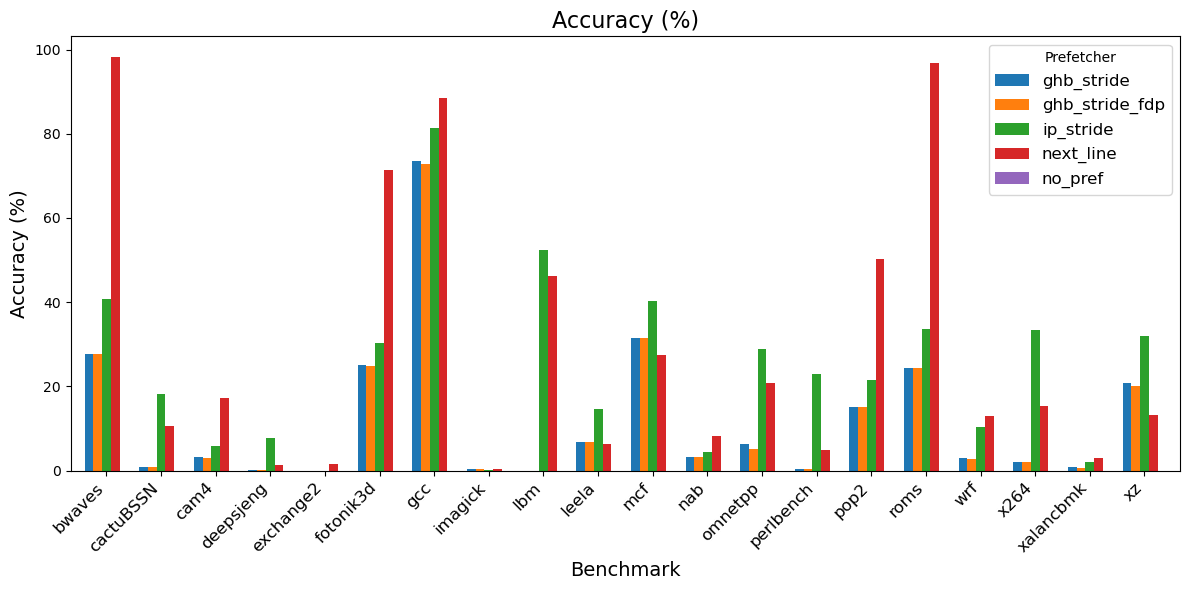

In [11]:
prefetchers = ['no_pref','next_line','ip_stride','ghb_stride', 'ghb_stride_fdp']
# Select the prefetchers you want to plot
plot_grouped_bar_chart(results_df, prefetchers, 'IPC')
plot_grouped_bar_chart(results_df, prefetchers, 'L2C Miss Latency')
plot_grouped_bar_chart(results_df, prefetchers, 'Coverage (%)')
plot_grouped_bar_chart(results_df, prefetchers, 'Accuracy (%)')
